In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import time
from scipy import interpolate
import matplotlib.colors as colors
from matplotlib import style
from matplotlib.patches import Rectangle
from numpy.linalg import matrix_power
import cvxpy as cp

In [2]:
# finding the value of Gamma_k, a helper
def Gamma(F,G,K,k):
    n=F.shape[0]
    Gamma_k = np.zeros([n, n])
    for h in range(k+1):
        Gamma_k += matrix_power(F-G@K,h)@G@K@matrix_power(F-G@K,k-h)
    return Gamma_k

In [3]:
# finding the value of x_0' at any k
def xk_prime(F_K,k,x_0_prime):
    xk_prime = matrix_power(F_K,k)@x_0_prime
    return xk_prime
    # finding the mean value of x_0'' at any k
    
def bar_xk_Dprime(F_K,k,x_0_Dprime,x_0_prime):
    bar_x_Dprime = matrix_power(F_K,k)@x_0_Dprime + Gamma(F,G,K,k-1)@x_0_prime
    return bar_x_Dprime

In [4]:
# calculating constant values \mathcal A1, A2 of J_c(x_0')
def A1_and_A2(F,G,K,Q,R,N):
    A1=Gamma(F,G,K,N-1).T@Q@Gamma(F,G,K,N-1)
    A2=np.zeros(F.shape)
    F_K=F+G@K
    for k in range(N):
        A1 += Gamma(F,G,K,k-1).T@Q@Gamma(F,G,K,k-1) + (matrix_power(F_K,k) + 
                Gamma(F,G,K,k-1)).T@K.T@R@K@(matrix_power(F_K,k) + Gamma(F,G,K,k-1))
        A2 += matrix_power(F_K,k).T@Q@Gamma(F,G,K,k-1) + matrix_power(F_K,k).T@Q@(matrix_power(F_K,k) + Gamma(F,G,K,k-1))
    return A1/N, A2/N


In [5]:
# linear constraints TTx <= hh, find TT and hh
def Constraints(T,S,x0pp,uBar,xBar,F,K,Sigmapp1,Sigma_w,t,m,N,G):
    n=T.shape[0]
    v=T.shape[1]
    n_u=S.shape[0]
    TTx=np.full((N*n, v), np.nan)
    hhx=np.full((N*n, 1), np.nan)
    TTu=np.full((N*n_u, v), np.nan)
    hhu=np.full((N*n_u, 1), np.nan)

    for k in range(1,N+1):
        j=k-1
        TTx[range(j*n,k*n), :] = T@Gamma(F,G,K,k-1)
        hhx[range(j*n,k*n), :] = xBar-np.sqrt((t-eGammalon)/eGammalon)*\
            np.sqrt(np.diag(T@Sigmapp1@T.T).reshape(t,1))-T@matrix_power(F,k)@x0pp
        if (k<N):
            TTu[range(j*n_u,k*n_u), :] = S@K@matrix_power(F+G@K,k)
            hhu[range(j*n_u,k*n_u), :] = uBar-np.sqrt((m-eGammalon)/eGammalon)*\
                np.sqrt(np.diag(S@K@Sigma_w@K.T@S.T).reshape(m,1))
        else:
            TTu[range(j*n_u,k*n_u), :] =  S@K
            hhu[range(j*n_u,k*n_u), :] = uBar

    TT=np.concatenate((TTx, TTu))
    hh=np.concatenate((hhx, hhu))

    return TT, hh
    
        


In [6]:
# 1 step of the kalman filter: time update then measurement update
def KF_1step(y1,Q,R,F,G,H,p00,x00,u):
    # k+1|k
    x10=F@x00+G@u
    p10=F@p00@F.T+Q
    # k+1|k+1
    Kt=p10@H.T@np.linalg.inv(H@p10@H.T+R)
    x11=x10+Kt@(y1-H@x10)
    p11=p10-Kt@H@p10
    return x11, p11

In [7]:
# true trajectory that will be used to generate future y's
def trueTraj(x0,F,G,u,H,var_w,var_v):
    x1 = F@x0+G@u+np.sqrt(var_w)@np.random.randn(x0.shape[0], x0.shape[1])
    y1 = H@x1+ np.sqrt(var_v)@np.random.randn(H.shape[0],1)
    return x1, y1

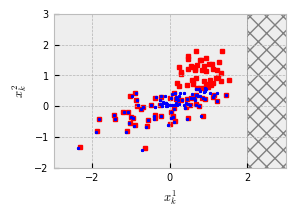

In [8]:
# Plotting
plt.style.use('bmh')
fig= plt.figure(figsize=(3.0,2.0))
rectangle = plt.Rectangle((2,-10), 20, 20, fc='None',ec="grey", hatch='xx',zorder=1)
plt.gca().add_patch(rectangle)

plt.xticks(fontsize=7)  
plt.yticks(fontsize=7)  
plt.xlabel('$x^1_k$', fontsize=9)  
plt.ylabel('$x^2_k$', fontsize=9) 
plt.xlim([-3, 3])

plt.rc( 'text', usetex=True )
# State dynamics
F=np.array([[1,0.0075],[-0.143,0.996]])
G=np.array([[4.798,0.115]]).T
var_x0=np.diag(np.array([0.1,0.1]))
mu_x0=-np.array([[0.6455,1.3751]]).T
var_w=np.diag(np.array([0.1,0.1]))

# Measurement equation
H=np.array([[1,0],[0,1]])
var_v=np.diag(np.array([0.5,0.4]))

# LQR: costs and gain
Q=np.diag([1,10])
R=10*np.eye(G.shape[1])
K=-np.array([[0.2409   , -0.3930]])#, [0.0726  ,  0.5789]])

# Constraints
T=np.array([[1,0]])
S=np.array([[0]])
xBar=np.array([[2]]).T
uBar=1000000

# Few parameters
n=F.shape[0]
t=T.shape[0]
m=S.shape[0]

# N: prediction horizon, T: horizon, eGammalon: tolerance
N=8
T_horizon=100
eGammalon=0.2

# Initialize algorithm
A1, A2 = A1_and_A2(F,G,K,Q,R,N)
Sigmas11 = np.full((T_horizon,1),np.nan)
x0ps = np.full((T_horizon*n,1),np.nan)
x0pps = np.full((T_horizon,1),np.nan)
Sigmapp0 = var_x0
xpp0 = mu_x0
xpp0_true=np.sqrt(var_x0)@np.random.randn(n,1)+mu_x0
x1_true_rec=np.full((T_horizon,1),np.nan)
y1s=np.full((T_horizon,),np.nan)
for k in range(T_horizon):
    plt.plot(xpp0[0],xpp0[1],'sr',ms=2.5,zorder=1)
    # Construct the problem.
    Sigmapp1 = F@Sigmapp0@F.T + var_w
    TT, hh = Constraints(T,S,xpp0,uBar,xBar,F,K,Sigmapp1,var_w,t,m,N,G)
    x0p = cp.Variable((n,1))
    objective = cp.Minimize(cp.quad_form(x0p, A1)+xpp0.T@A2@x0p)
    #hh=hh.reshape(N*(t+m),)
    constraints = [TT@x0p <= hh]
    constraintsManual=[T@x0p<=2]
    for jj in range(1,N+1):
        constraintsManual += [T@Gamma(F,G,K,jj-1)@x0p<= xBar-np.sqrt((t-eGammalon)/eGammalon)*np.sqrt(np.diag(T@Sigmapp1@T.T).reshape(t,1))-T@matrix_power(F,jj)@xpp0]


    prob = cp.Problem(objective,constraintsManual)#)#, constraints)
    # The optimal objective value is returned by `prob.solve()`.
    result = prob.solve()
    # The optimal value for x is stored in `x.value`.
    x0star = x0p.value
    x0ps[range(k*n,(k+1)*n),:] = x0star.reshape(n,1)
    Sigmas11[k,:] = Sigmapp0[0,0]
    x0pps[k,:] = xpp0[0,0]
    x1_true_rec[k,:]=xpp0_true[0]
    u = np.array((K@x0star).reshape(1,1))
    #u = np.array((K@xpp0).reshape(1,1))
    xpp0_true, y1 = trueTraj(xpp0_true,F,G,u,H,var_w,var_v)
    #y1s[k]=y1
    xpp0, Sigmapp0 = KF_1step(y1,var_w,var_v,F,G,H,Sigmapp0,xpp0,u)
    plt.plot(x0star[0],x0star[1],'*b',ms=2,zorder=2)
    #plt.plot(xpp0_true[0],xpp0_true[1],'.k')
plt.ylim([-2, 3]) 
plt.savefig('figs/LinearStateSelection.pdf',bbox_inches ="tight")
plt.xticks(fontsize=7)  
plt.yticks(fontsize=7) 

plt.show()


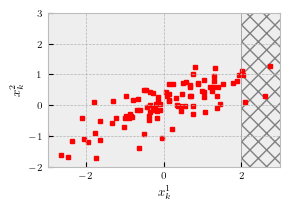

In [9]:
# Plotting
#With particle filter conditional mean
plt.style.use('bmh')
fig= plt.figure(figsize=(3.0,2.0))
rectangle = plt.Rectangle((2,-10), 20, 20, fc='None',ec="grey", hatch='xx',zorder=1)
plt.gca().add_patch(rectangle)

plt.xticks(fontsize=7)  
plt.yticks(fontsize=7)  
plt.xlabel('$x^1_k$', fontsize=9)  
plt.ylabel('$x^2_k$', fontsize=9) 
plt.xlim([-3, 3])
plt.ylim([-2, 3])

# Initialize algorithm
Sigmapp0 = var_x0
xpp0 = mu_x0
xpp0_true=np.sqrt(var_x0)@np.random.randn(n,1)+mu_x0
y1s=np.full((T_horizon,),np.nan)
for k in range(T_horizon):
    plt.plot(xpp0[0],xpp0[1],'sr',ms=3,zorder=1)
    # Construct the problem.
    u = np.array((K@xpp0).reshape(1,1))
    xpp0_true, y1 = trueTraj(xpp0_true,F,G,u,H,var_w,var_v)
    #y1s[k]=y1
    xpp0, Sigmapp0 = KF_1step(y1,var_w,var_v,F,G,H,Sigmapp0,xpp0,u)
    #plt.plot(xpp0_true[0],xpp0_true[1],'.k')

plt.savefig('figs/LinearStateSpaceLQROnly.pdf',bbox_inches ="tight")
plt.show()


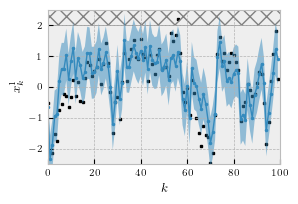

In [10]:
plt.style.use('bmh')
fig= plt.figure(figsize=(3.0,2.0))
rectangle = plt.Rectangle((-1,2), 200, 20, fc='None',ec="grey", hatch='xx',zorder=1)
plt.gca().add_patch(rectangle)
sigmas=np.sqrt(Sigmas11).reshape(T_horizon,)
k=range(T_horizon)
x=x0pps.reshape(T_horizon,)
nn=2
y1 = x-nn*sigmas
y2 = x+nn*sigmas

# plot
plt.xticks(fontsize=7)  
plt.yticks(fontsize=7)  
plt.xlabel('$k$', fontsize=9)  
plt.ylabel('$x^1_k$', fontsize=9) 

plt.fill_between(k, y1, y2, alpha=.5, linewidth=0)
plt.plot(k, x, '-o', ms=1.5 , linewidth=1)
plt.plot(k,x1_true_rec,'sk',ms=2,linewidth=1,zorder=0)
plt.xlim([0, 100])
plt.ylim([-2.5, 2.5])
plt.savefig('figs/Linear2Sigmas.pdf',bbox_inches ="tight")
plt.show()